In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-10-17 09:00:32--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-10-17 09:00:32 (25.5 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5710736/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5710736/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [2]:

!pip install setuptools --upgrade

!pip install git+https://github.com/CUQI-DTU/CUQIpy-FEniCS.git@sprint13_observation_bug#egg=CUQIpy-FEniCS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 15.2 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
numba 0.56.2 requires setuptools<60, but you have setuptools 65.5.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/CUQI-DTU/CUQIpy-FEniCS.git (to revision sprint13_observation_bug) to /tmp/pip-install-raw4o3s8/cuqipy-fenics_a9f7146cfce544089f4413397817c31f
  Running command git clone -q https://github.com/CUQI-DTU/CUQIpy-FEniCS.git /tmp/pip-install-raw4o3s8/cuqipy-fenics_a9f7146cfce544089f4413397817c31f
  Running command git checkout -b sprint13_observation_bug --track origin/sprint13_observation_bug
  Switched to a new branch 'sprint13_observation_bug'
  Branch 'sprint13_observation_bug' set up to track remote branch 'sprint13_observation_bug' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 14.0 MB/s 
  Created wheel for CUQIpy-FEniCS: filename=CUQIpy_FEniCS-0.1.1.post0.dev1-py3-none-any.whl size=35690 sha256=2caed1f68bcffe42c436a393a

In [3]:
pip install cuqipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install cuqipy_fenics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import dolfin as dl
import numpy as np
import cuqipy_fenics
import cuqi
import mshr
import matplotlib.pyplot as plt

In [38]:
#%% 1.1 Define domain and mesh
domain = mshr.Circle(dl.Point(0,0),1)
mesh = mshr.generate_mesh(domain, 20)

#%% 1.2 Define function spaces 
parameter_space = dl.FunctionSpace(mesh, "CG", 1)
solution_space = dl.FunctionSpace(mesh, "CG", 1)

#%% 1.3 Define boundary input as source term
class boundary_input(dl.UserExpression):
    def set_freq(self, freq=1.):
        self.freq = freq
    def eval(self, values, x, tag='sin'):
        theta = np.arctan2(x[1], x[0])
        values[0] = np.sin(self.freq*theta)

boundary = lambda x, on_boundary: on_boundary

FEM_el = solution_space.ufl_element()

bc_func = boundary_input(element=FEM_el)
bc_func.set_freq(freq=2.)

bc = dl.DirichletBC(solution_space, bc_func, boundary)

w = dl.Function(solution_space)
bc.apply(w.vector())

#%% 1.3.1 Defining zero boundary for the extended problem
u0 = dl.Constant('0.0')
zero_bc = dl.DirichletBC(solution_space, u0, boundary)

#%% 1.4 Define Poisson problem form
class form():
  def set_w(self, w):
    self.w = w
  def form(self, kappa, u, v):
    return dl.inner( kappa*dl.grad(u), dl.grad(v) )*dl.dx + dl.inner( dl.grad(self.w), dl.grad(v) )*dl.dx

forms = []
residuals = []
for i in range(1,5):
  bc_func = boundary_input(element=FEM_el)
  bc_func.set_freq(freq=i)

  bc = dl.DirichletBC(solution_space, bc_func, boundary)

  w = dl.Function(solution_space)
  bc.apply(w.vector())

  temp_form = form()
  temp_form.set_w( w )
  forms.append( temp_form )


#u = dl.TrialFunction(solution_space)
#v = dl.TestFunction(solution_space)

#for i in range(3):
#  A = dl.lhs(forms[i].form(1,u,v))
#  b = dl.rhs(forms[i].form(1,u,v))

#  solution = dl.Function(solution_space)
#  dl.solve(A==b,solution,zero_bc)
#  plt.figure()
#  dl.plot(solution + forms[i].w)



#%% 1.6 Define observation map (applied to the solution to generate the 
# observables)

#%% 1.6.1 extracting the index of boundary elements

class observation():
  def __init__(self):
    dummy = dl.Function(solution_space)
    dummy.vector().set_local( np.ones_like( dummy.vector().get_local() ) )
    zero_bc.apply( dummy.vector() )
    self.bnd_idx = np.argwhere( dummy.vector().get_local() == 0 ).flatten()

    self.normal_vec = dl.FacetNormal( mesh )
    self.tests = dl.TestFunction( solution_space )

  def set_w(self, w):
    self.w = w

  def obs_func(self, kappa, u):
    obs_form = dl.inner( dl.grad(u + self.w), self.normal_vec )*self.tests*dl.ds
    obs = dl.assemble( obs_form )
    return obs.get_local()[self.bnd_idx]

obs_funcs = []
for i in range(4):
  temp_obs_func = observation()
  temp_obs_func.set_w( forms[i].w )
  obs_funcs.append( temp_obs_func )

#u = dl.TrialFunction(solution_space)
#v = dl.TestFunction(solution_space)

#for i in range(4):
#  A = dl.lhs(forms[i].form(1,u,v))
#  b = dl.rhs(forms[i].form(1,u,v))

#  solution = dl.Function(solution_space)
#  dl.solve(A==b,solution,zero_bc)
#  plt.figure()
#  dl.plot(solution + forms[i].w)

#  bnd_vals = obs_funcs[i].obs_func(1,solution + forms[i].w)

#  temp = dl.Function(solution_space)
#  vec = np.zeros_like( temp.vector().get_local() )
#  vec[ obs_funcs[i].bnd_idx ] = bnd_vals
#  temp.vector().set_local( vec )
#  plt.figure()
#  dl.plot( temp )

#%% 2.1 Create the domain geometry
# 2.1.1 The space on which the Bayesian parameters are defined
fenics_continuous_geo = cuqipy_fenics.geometry.FEniCSContinuous(parameter_space)

# 2.1.2 The Matern fieled (maps i.i.d normal random vector of dimension `num_terms`
# to Matern field realization on `fenics_continuous_geo`)
matern_geo = cuqipy_fenics.geometry.MaternExpansion(fenics_continuous_geo, length_scale = .2, num_terms=64)

# 2.1.3 We create a map `heavy_map` to map the Matern field realization to two levels
# c_minus and c_plus 
c_minus = 1
c_plus = 10

ones_vec = np.ones(94)
def heavy_map(func):
    dofs = func.vector().get_local()
    updated_dofs = c_minus*0.5*(1 + np.sign(dofs)) + c_plus*0.5*(1 - np.sign(dofs))

    updated_dofs[bnd_idx] = np.ones(94)
    func.vector().set_local(updated_dofs)
    return func

# 2.1.4 Finally, we create the domain geometry which applies the
# map `heavy_map` on Matern realizations.
domain_geometry = cuqipy_fenics.geometry.FEniCSMappedGeometry(matern_geo, map = heavy_map)

#%% 2.2 Create the range geomtry 
range_geometry = cuqi.geometry.Continuous1D(94)


#%% 2.5 Create a prior
pr_mean = np.zeros(domain_geometry.par_dim)
prior = cuqi.distribution.GaussianCov(pr_mean, cov=np.eye(domain_geometry.par_dim), geometry= domain_geometry, name='x')

#%% 2.6 Define the exact solution
exactSolution = prior.sample()

#%% 2.3 Create CUQI PDE (which encapsulates the FEniCS formulation
# of the PDE) and Create CUQI model

PDE_models = []
models = []
b_exact = []
sigma2 = []
data_dists = []
datas = []

for i in range(4):
  PDE_model = cuqipy_fenics.pde.SteadyStateLinearFEniCSPDE( forms[i].form, mesh, solution_space, parameter_space,zero_bc, observation_operator=obs_funcs[i].obs_func)
  PDE_models.append( PDE_model )
  models.append( cuqi.model.PDEModel( PDE_model,range_geometry,domain_geometry)  )

  #%% 2.7 Generate exact data 
  b_exact.append( models[i](exactSolution) )

  #%% 2.8 Create the data distribution
  SNR = 100
  sigma = np.linalg.norm(b_exact[i])/SNR/np.sqrt(94)
  sigma2.append( sigma*sigma ) # variance of the observation Gaussian noise
  data_dists.append( cuqi.distribution.GaussianCov(models[i], sigma2[i]*np.ones(range_geometry.par_dim), geometry=range_geometry, name='y{}'.format(i+1)) )

  #%% 2.9 Generate noisy data
  datas.append( data_dists[i](x=exactSolution).sample() )

#%% 2.10 Create the joint data distribution and the joint likelihood
posterior = cuqi.distribution.JointDistribution(prior,data_dists[0],data_dists[1],data_dists[2],data_dists[3])(y1=datas[0], y2=datas[1], y3=datas[2], y4=datas[3])._as_stacked()



Sample 1000 / 1000

Average acceptance rate: 0.096 MCMC scale: 0.06230119291624149 



AttributeError: ignored

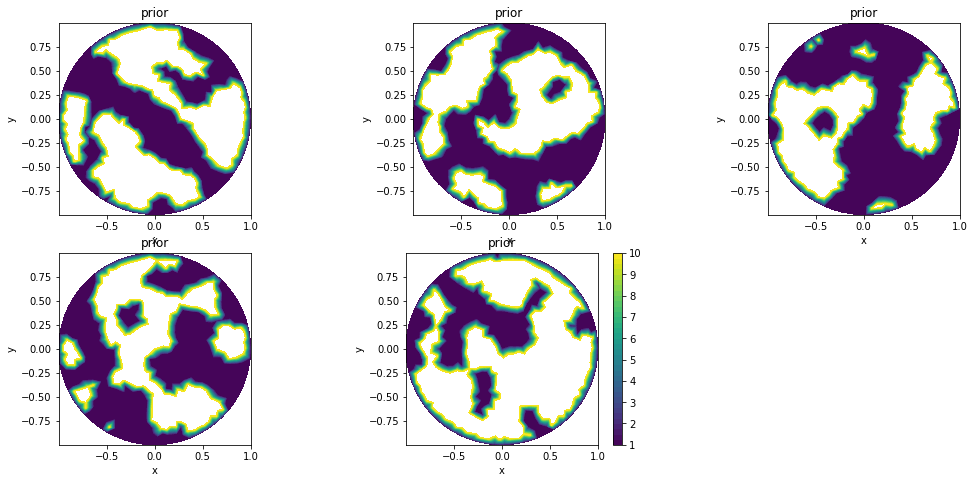

In [40]:
#%% 3 Third, we define a pCN sampler, sample, and inspect the prior and the posterior samples. 

#%% 3.1 Plot the exact solution
exactSolution.plot()

#%% 3.2 Plot prior samples
prior_samples = prior.sample(5)
ims = prior_samples.plot(title="prior")
plt.colorbar(ims[-1])


#%% 3.3 Create pCN Sampler 
Sampler = cuqi.sampler.MetropolisHastings(
    posterior,
    scale=None,
    x0=None,
)

#%% 3.4 Sample using the pCN sampler
samples = Sampler.sample_adapt(1000)

#%% 3.5 Plot posterior pCN samples 
ims = samples.plot([0, 100, 300, 600, 800, 900],title="posterior")
plt.colorbar(ims[-1])

# %% 3.6 Plot trace and autocorrelation (pCN)
samples.plot_trace()
samples.plot_autocorrelation(max_lag=300)

#%% 3.7 Plot credible interval (pCN)
plt.figure()
samples.plot_ci(plot_par = True, exact=exactSolution)
plt.xticks(range(128)[::20], range(128)[::20])
plt.title("Credible interval")
# %%

